<a href="https://colab.research.google.com/github/junghyeon0114/hands_on/blob/main/ch03_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

09/04 핸즈온 3장 분류 p.127~154

#CH03 분류

**3.1 MNIST**

In [28]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖음

- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키

In [29]:
X, y = mnist["data"], mnist['target']
print('X.shape:',X.shape)
print('y.shape:', y.shape)

# 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음.

X.shape: (70000, 784)
y.shape: (70000,)


<function matplotlib.pyplot.show(close=None, block=None)>

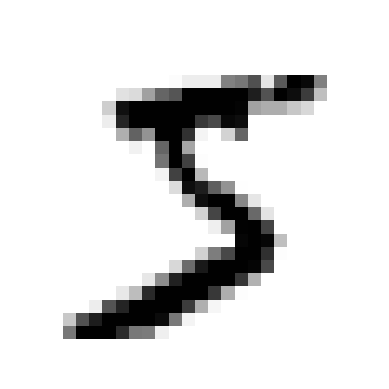

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show

In [32]:
y[0]

'5'

In [34]:
import numpy as np

In [35]:
y= y.astype(np.uint8)

In [36]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**3.2 이진 분류기 훈련**

In [38]:
#분류 작업을 위해 타깃 벡터 만들기

y_train_5 =( y_train==5)
y_test_5 = (y_test==5)

In [39]:
#SGDClassifier 모델 만들고 전체 훈련 세트 사용해 훈련.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [41]:
#모델을 이용해 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

**3.3 성능 측정**

분류기 평가는 회귀 모델보다 훨씬 어려움.



In [44]:
# 3.3.1 교차 검증 사용
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correst = sum(y_pred == y_test_fold)
  print(n_correst / len(y_pred))


0.95035
0.96035
0.9604


In [47]:
# cross_val_score( ) 함수

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [48]:
# 더미 분류기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [50]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

**오차 행렬**

오차행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 함.

In [51]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict( ) 함수는 K-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환.

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [54]:
y_train_perfect_predictions = y_train_5       #완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

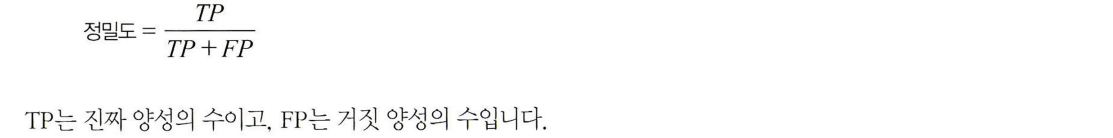

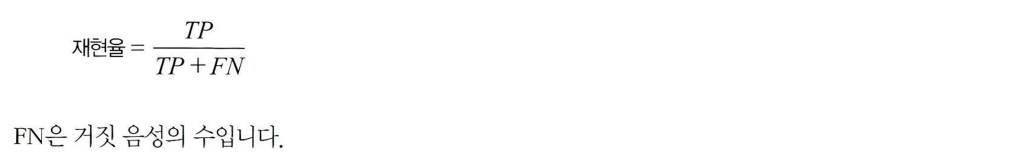

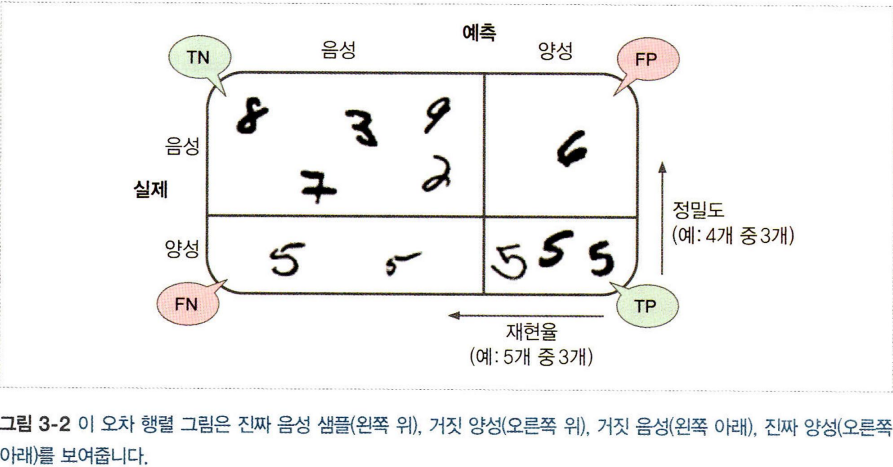

**3.3.3 정밀도와 재현율**



In [55]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [56]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 점수는 정밀도와 재현율의 조화 평균

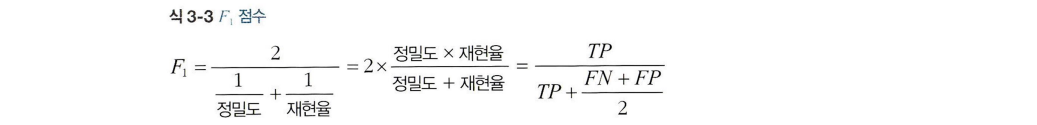

In [57]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음
- 정밀도와 재현율은 반비례 관계


**3.3.4 정밀도/재현율 트레이드오프**

결정 함수를 사용해 각 샘플의 점수를 계산.

임곗값보다 크면 샘플을 양성 클래스에, 아니면 음성 클래스에 할당.

In [58]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [61]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [62]:
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

위의 결과를 통해 임곗값을 높이면 재현율은 줄어드는 것을 알 수 있다.

- 적절한 임곗값 구하기

1) cross_val_predict() 통해 훈련 세트에 있는 모든 샘플의 점수를 구하기

In [73]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [74]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show(close=None, block=None)>

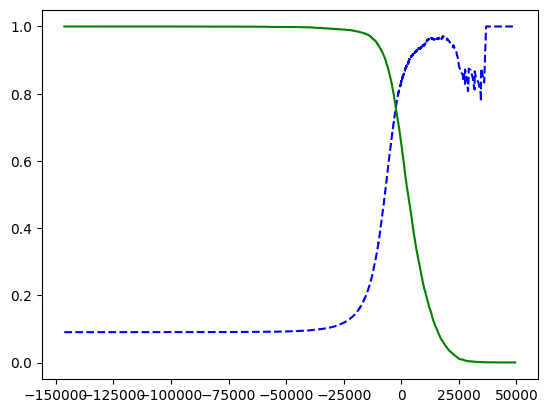

In [75]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label= "정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  [...]         # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가합니다.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

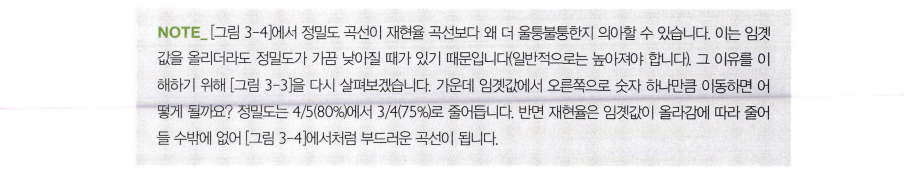

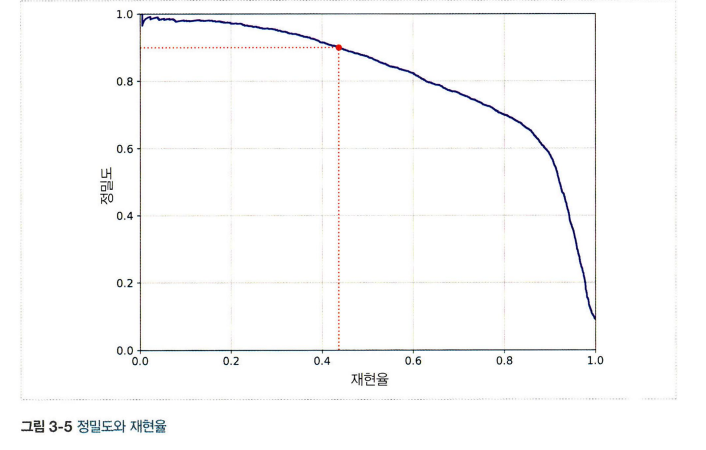

정밀도 그래프가 급격하게 줄어들기 시작하는 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음.


In [76]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [77]:
y_train_pred_90 = (y_scores > threshold_90_precision)

예측에 대한 정밀도와 재현율 확인

In [79]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [80]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않음.

**3.3.5 ROC 곡선**

수신기 조작 특성 곡선(ROC곡선)도 이진 분류에서 널리 사용하는 도구.

정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선.

TNR을 특이도라고 함.

따라서 ROC 곡선은 민감도에 대한 1-특이도 그래프임


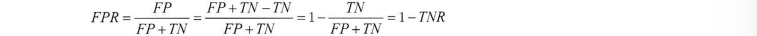

In [81]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

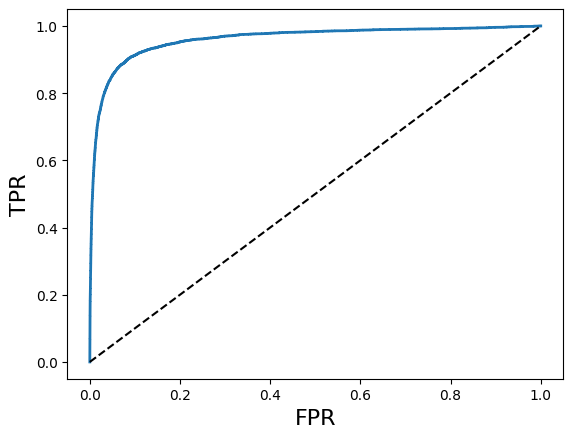

In [85]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')       # 대각 점선
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

- 곡선 아래의 면적을 측정하면 분류기들을 비교할 수 있음. 완벽한 분류기는 ROC의 AUC가 1이고 완전한 랜덤 분류기는 0.5이다.

- 사이킷런은 ROC의 AUC를 계산하는 함수를 제공

In [86]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- predict_proba( )
: 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [87]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

- roc_curve( ) : 레이블과 점수를 기대. 점수 대신에 클래스 확률 전달 가능.

In [88]:
y_scores_forest = y_probas_forest[:, 1]     # 양성 클래스에 대한 확률을 점수로 사용.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

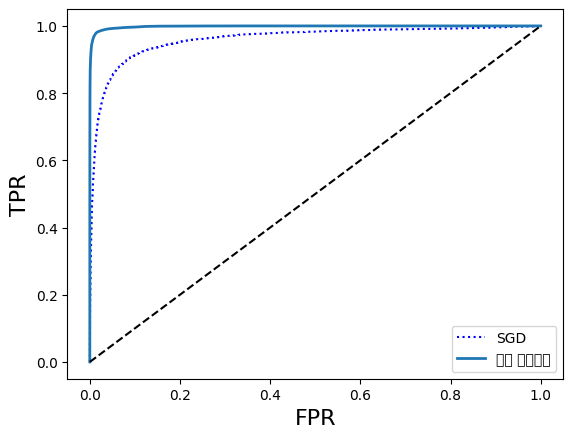

In [89]:
# ROC 곡선 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

랜덤 포레스트의 ROC 곡선이 왼쪽 위 모서리에 가까움 (= AUC 값이 큼)

==>랜덤 포레스트 분류기가 SGD보다 훨씬 좋음.

In [90]:
# 정밀도, 재현율 점수
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

**3.4 다중 분류**



In [91]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [92]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([2164.22030239])

In [93]:
np.argmax(some_digit_scores)

0

In [94]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [95]:
svm_clf.classes_[5]

5

In [96]:
# SVC 기반 OvR 전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsOneClassifier

ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [97]:
len(ovr_clf.estimators_)

45

In [98]:
# SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [99]:
#SGDClassifier 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [102]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

array([0.8983, 0.891 , 0.9018])

**3.5 에러 분석**



In [103]:
# 오차 행렬

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

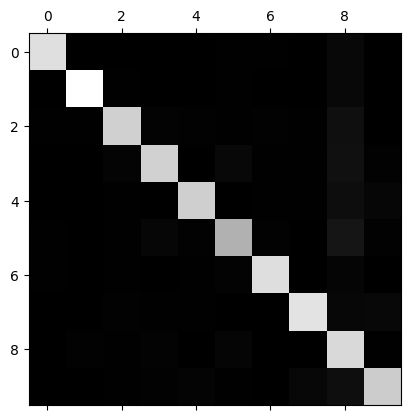

In [104]:
# 오차 행렬을 맷플롯립의 matshow( ) 함수를 이용해 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [105]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

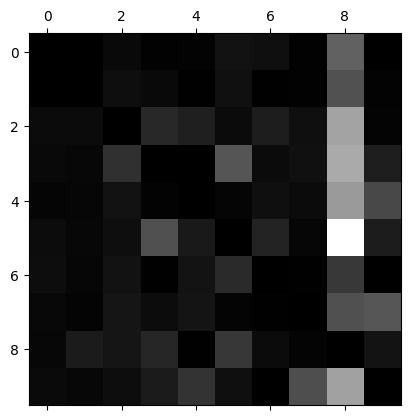

In [106]:
#주대각선 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [108]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

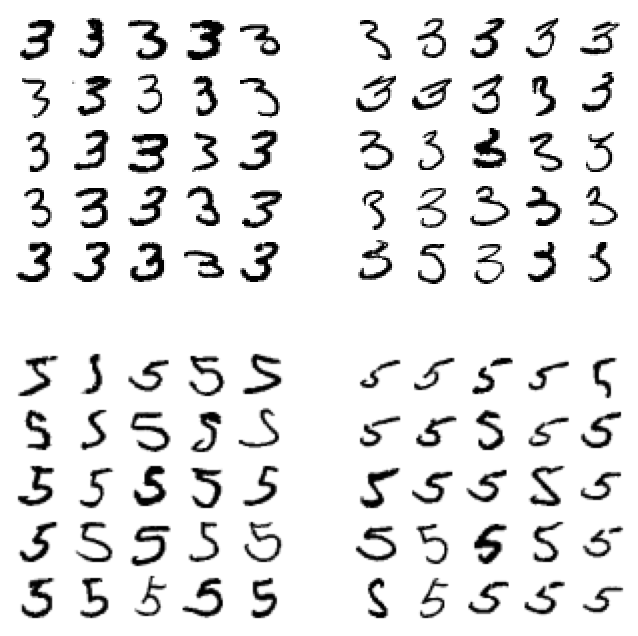

In [109]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

**3.6 다중 레이블 분류**



In [110]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [111]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [113]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

**다중 출력 분류**


In [114]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [115]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

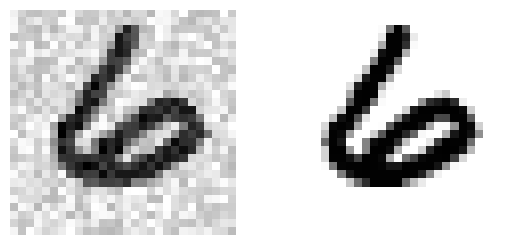

In [116]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

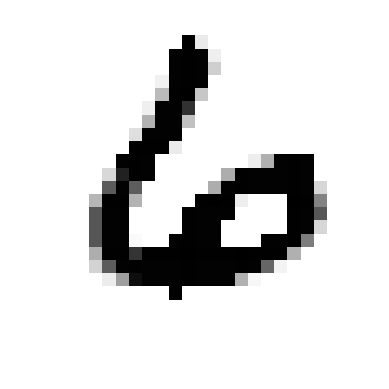

In [117]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)